In [ ]:
# embeddings are working
# turn the classification code into a function
# get the scores for the 3 types of embeddings 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

In [2]:
#ind_data = r"C:\space\elton\UT\TextAnalysis\transcript_embeddings\data\exp_12_15_351_utterances_processed.csv"
ind_data = r"Z:\\elton\UT\TextAnalysis\transcript_embeddings\data\exp_12_15_351_utterances_processed_noReplace.csv"


df = pd.read_csv(ind_data)
df = df[df["JA"].notnull()]

df["utterance"] = df["utterance"].str.lower()
df_tokens = " ".join(df["utterance"]).split()
unique_tokens = list(set(df_tokens))
unique_tokens.sort()

indexes = [i for i in range(0, len(unique_tokens))]

vocab = dict(zip(unique_tokens, indexes))
reverse_vocab = dict(zip(indexes, unique_tokens))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


model_ind = r"C:\space\elton\UT\TextAnalysis\transcript_embeddings\models\4_2-10epoch.pt"
model_ind = r"Z:\elton\UT\TextAnalysis\transcript_embeddings\models\noReplace.pt"
model_ft = torch.load(model_ind)
print(model_ft.embeddings.weight[vocab["toy"]])

tensor([ 0.0359, -0.2366, -0.4932,  0.0059, -1.6442,  0.5322, -1.0430, -1.2863,
        -0.7036,  1.1092], device='cuda:0', grad_fn=<SelectBackward0>)


In [3]:
from sklearn.decomposition import PCA


def get_gensim_emb(weights, vocab, emb_dim):
    embs = []
    count = 0

    for word in vocab:
        try:
            embs.append(weights[word])
        except:
            embs.append(np.zeros(emb_dim,))

        count +=1
    print(count)
    return np.array(embs)
    

def reduce_embeddings(embeddings):
    """
    reduces embeddings 
    """
    pca = PCA()
    pca.fit(embeddings)
    return pca.transform(embeddings), pca


def sentence_helper(sentence, embeddings, vocab, emb_type="torch"):
    sentence = sentence.split()
    token_emb = []

    for word in sentence:

        if emb_type == "gensim":
            if embeddings.sum() != 0:
                token_emb.append(embeddings[vocab[word.strip()]])
        elif emb_type == "torch":
            try:
                token_emb.append(embeddings[vocab[word.strip()]])
            except Exception as e:
                print(e)
    token_emb = np.array(token_emb)
    sentence_emb = np.sum(token_emb, axis=0)

    return sentence_emb


def sentence_embeddings(embeddings):
    """
    takes a set of embeddings 
    """

    dff = df.sort_values(by="JA")
    ja_index = dff.shape[0] - ((df["JA"]==1).sum()) 
    sentence_emb = np.stack(dff["utterance"].apply(lambda x: sentence_helper(x, embeddings, vocab)).values)
    
    sentence_emb, _ = reduce_embeddings(sentence_emb)
    reduced_emb, _ = reduce_embeddings(embeddings)


    no_sentence_emb = np.copy(sentence_emb[: ja_index, :])
    ja_sentence_emb = np.copy(sentence_emb[ja_index: , :])

    return no_sentence_emb, ja_sentence_emb, reduced_emb
    


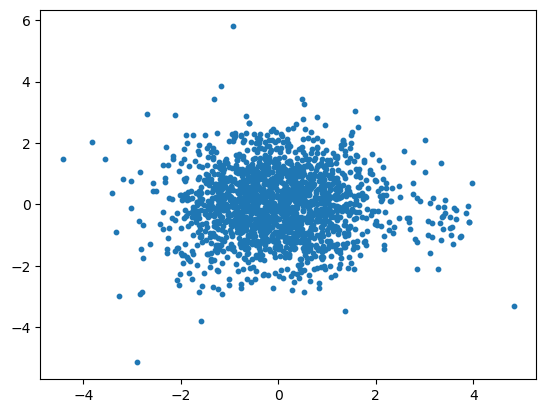

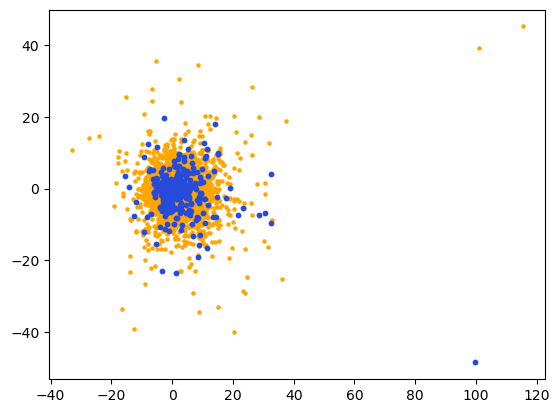

In [90]:
inhouse_emb = np.array(model_ft.embeddings.weight.data.to("cpu"))

reduced_emb, _ = reduce_embeddings(inhouse_emb)
plt.scatter(reduced_emb[:,0], reduced_emb[:, 1], s=10)
plt.show()

no_emb, ja_emb, reduced_emb = sentence_embeddings(inhouse_emb)
plt.scatter(no_emb[:,0], no_emb[:, 1], s=5 , c="orange")
plt.scatter(ja_emb[:,0], ja_emb[:, 1], s=10, c="#264AD9")
plt.show()


In [40]:
from gensim import utils


class MyCorpusDf:
    """An iterator that yields sentences (lists of str)."""

    def __iter__(self):
        self.df = df 
        for line in self.df.itertuples():
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line[-2])


import gensim.models

sentences = MyCorpusDf()
model = gensim.models.Word2Vec(epochs=50, sentences=sentences, sg=1, vector_size=300, window = 30, compute_loss=True, )
model.get_latest_training_loss()
 

11914716.0

1742


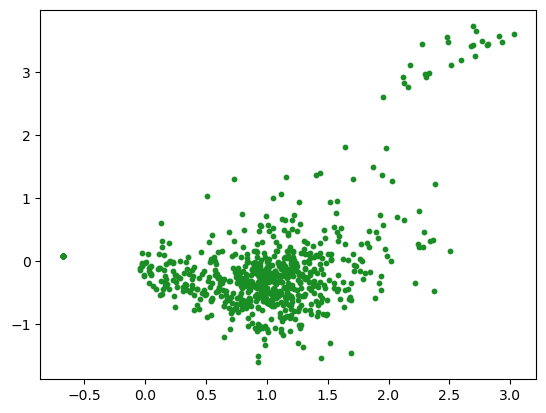

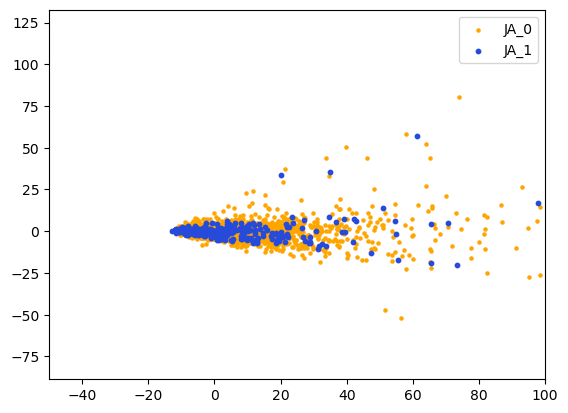

In [41]:
gensim_embs = get_gensim_emb(model.wv, vocab, 300)

no_gen_emb, ja_gen_emb, reduced_gen_emb = sentence_embeddings(gensim_embs)
plt.scatter(reduced_gen_emb[:,0], reduced_gen_emb[:, 1], s=10, c="#1a8e24")
#plt.title("ED word-level embeddings")
plt.show()


plt.scatter(no_gen_emb[:,0], no_gen_emb[:, 1], s=5 , c="orange", label="JA_0")
plt.scatter(ja_gen_emb[:,0], ja_gen_emb[:, 1], s=10, c="#264AD9", label="JA_1")
#plt.title("ED utterance-level embeddings")
plt.xlim(-50, 100)
plt.legend()
plt.show()

In [9]:
import gensim.downloader

google_news = gensim.downloader.load("word2vec-google-news-300")


1742


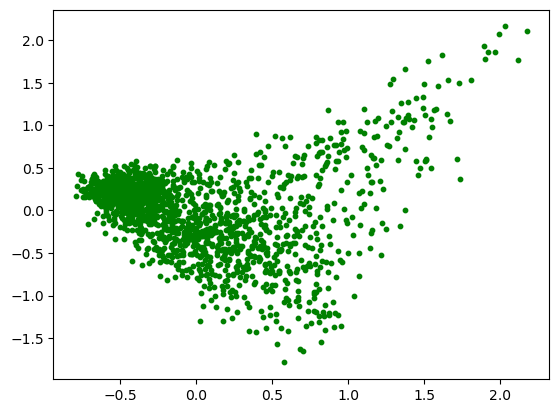

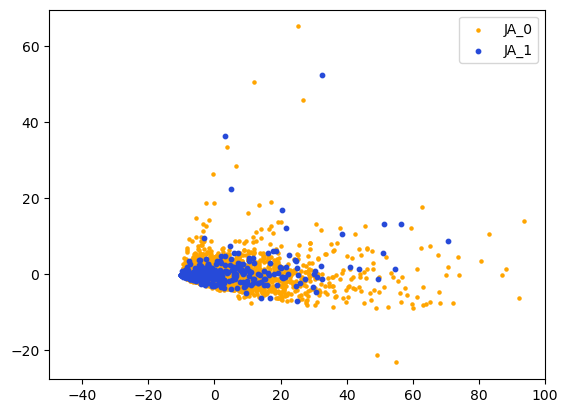

In [35]:
google_embs = get_gensim_emb( google_news, vocab, 300)

no_google_emb, ja_google_emb, reduced_google_emb = sentence_embeddings(google_embs)

plt.scatter(reduced_google_emb[:,0], reduced_google_emb[:, 1], s=10, c="green")
#plt.title("Google word-level embeddings")
plt.show()
plt.scatter(no_google_emb[:,0], no_google_emb[:, 1], s=5 , c="orange", label="JA_0")
plt.scatter(ja_google_emb[:,0], ja_google_emb[:, 1], s=10, c="#264AD9", label="JA_1")
#plt.title("Google utterance-level embeddings")
plt.xlim(-50, 100)
plt.legend()
plt.show()


### Classification
could not find a clear separation of space, with only embeddings so try a sequence of emeddings. 
We do this simply by adding embeddings vectors in order to see if there's a JA direction. This was we can 
still infer something from classification metrics rather than just accuracy

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score 
from sklearn.model_selection import train_test_split

def training_sent(negative, positive, balanced):

    if balanced:
        np.random.shuffle(negative)
        balanced = positive.shape[0]
        X = np.concatenate((negative[:balanced], positive))
        y = np.concatenate((np.zeros(balanced), np.ones(balanced)))

    else:
        X = np.concatenate((negative, positive))
        y = np.concatenate((np.zeros(negative.shape[0]), np.ones(positive.shape[0])))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    return X_train, X_test, y_train, y_test

def eval_sent(negative, positive, balanced):
    X_train, X_test, y_train, y_test = training_sent(negative, positive, balanced)

    clf = LogisticRegression(class_weight="balanced").fit(X_train, y_train)
    cof_matrix = confusion_matrix(y_test, clf.predict(X_test), normalize="all")

    return cof_matrix, clf.classes_ 

(4661, 300) (322, 300)


c:\Users\Elton\anaconda3\envs\cuda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


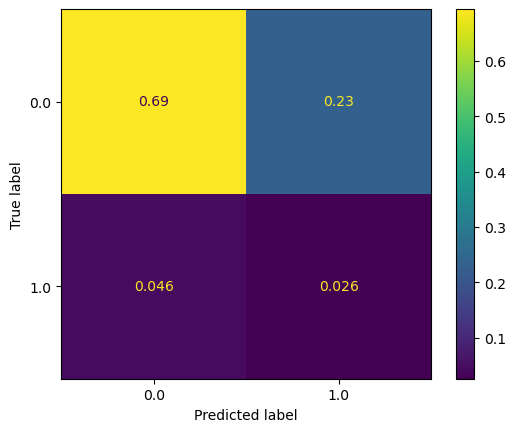

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay

print(no_gen_emb.shape, ja_gen_emb.shape)
cof_matrix, classes = eval_sent(no_gen_emb, ja_gen_emb, False)
ConfusionMatrixDisplay(confusion_matrix=cof_matrix, display_labels=classes).plot()
#plt.title("ED utterance-level classification/weighted")
plt.show()



(4661, 300) (322, 300)


c:\Users\Elton\anaconda3\envs\cuda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


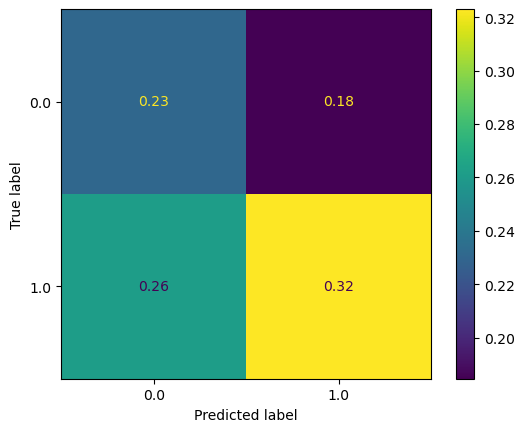

In [48]:
print(no_gen_emb.shape, ja_gen_emb.shape)
cof_matrix, classes = eval_sent(no_gen_emb, ja_gen_emb, True)
ConfusionMatrixDisplay(confusion_matrix=cof_matrix, display_labels=classes).plot()
#plt.title("ED utterance-level classification/truncated")
plt.show()

(4661, 300) (322, 300)


c:\Users\Elton\anaconda3\envs\cuda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


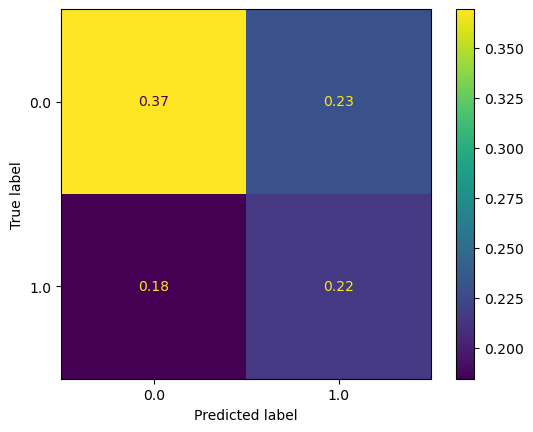

In [45]:
print(no_gen_emb.shape, ja_gen_emb.shape)
cof_matrix, classes = eval_sent(no_google_emb, ja_google_emb, True)
ConfusionMatrixDisplay(confusion_matrix=cof_matrix, display_labels=classes).plot()
#plt.title("Google utterance-level classification/runcated")
plt.show()


(4661, 300) (322, 300)


c:\Users\Elton\anaconda3\envs\cuda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


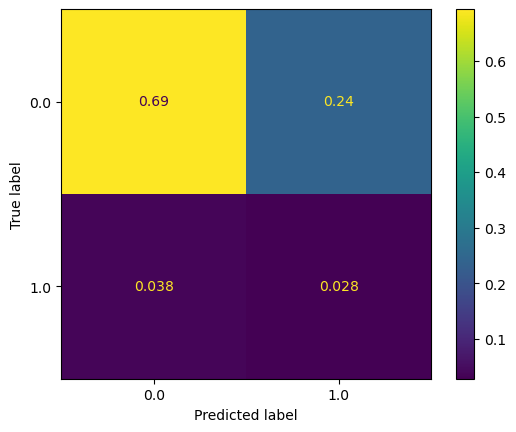

In [46]:
print(no_gen_emb.shape, ja_gen_emb.shape)
cof_matrix, classes = eval_sent(no_google_emb, ja_google_emb, False)
ConfusionMatrixDisplay(confusion_matrix=cof_matrix, display_labels=classes).plot()
#plt.title("Google utterance-level classification/weighted")
plt.show()


#### This was code for NN/LSTM classification model things went south so it was scraped. Should revisit 

In [57]:
from torch.utils.data import DataLoader, Dataset

class JointAttentionDataset(Dataset):
    """
    A subclass of pytorchs Dataset class to handle a
    pandas dataframe in the form of the defined csv for this
    experiment, must contain a JA and utterance column! 
    """
    
    def __init__(self, df):
        self.data = df.loc[:,["JA", "utterance"]]
    def __getitem__(self, idx):
        return self.data.iloc[idx,:]
    def __len__(self):
        return self.data.shape[0]


def sentence_pipeline(sentence, embeddings, vocab):
    sentence = sentence.split()
    sent_length = torch.tensor(len(sentence)).unsqueeze(dim=0).to(device)
    
    token_embeddings = [embeddings[vocab[word.strip()]].detach() for word in sentence]
    sentence_embeddings = torch.stack(token_embeddings, dim=0)
    avg_embeddings = torch.sum(sentence_embeddings, dim=0)

    sentence_features = torch.concat((sent_length, avg_embeddings), dim=0)
    return sentence_features 

def label_pipeline(label):

    try:
        label = torch.tensor(label, dtype=torch.long).to(device)
    except:
        print(label)
    return label


def collate_batch(batch, model, vocab):
    
    label_list, sentence_list, offsets = [], [], [0]
    for _label, _sentence in batch:
        label_list.append(label_pipeline(_label))
        sentence_list.append(sentence_pipeline(_sentence, model, vocab))
    label_list = torch.tensor(label_list).to(device)
    sentence_list = torch.stack(sentence_list, dim=0)

    return label_list, sentence_list

train_iter = JointAttentionDataset(df)
dataloader = DataLoader(
    train_iter, batch_size=3, collate_fn= lambda b, model=embeddings, vocab=vocab: collate_batch(b, embeddings, vocab) 
)


In [39]:
class TextClassificationModel(nn.Module):
    
    def __init__(self, embeddings, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        input_layer = embed_dim + 1
        hidden_layer = input_layer// 2
        self.embeddings = embeddings
        self.fc1 = nn.Linear(input_layer, hidden_layer)
        self.fc2 = nn.Linear(hidden_layer, num_class)
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.5
        self.embeddings.uniform_(-initrange, initrange)
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc2.bias.data.zero_()


    def forward(self, inputs):
        out = F.relu(self.fc1(inputs))
        out = self.fc2(out)
        log_probs = F.softmax(out, dim=1)

        return log_probs
    
    def predict(self, inputs):
        log_probs = self.forward(inputs.unsqueeze(dim=0))
        _, pred = torch.max(log_probs, 1)

        return pred


In [143]:
def train(dataloader):

    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(text)
        _, preds = torch.max(outputs, 1)
        #print(label)
        #print(predicted_label)
        #print(torch.max(predicted_label, 1))
        predicted.append((preds, label))

        loss = criterion(outputs, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (preds == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f} | loss {:2f}".format(
                    epoch, idx, len(dataloader), total_acc / total_count, loss
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

In [144]:
class_names = ["JA", "none"]
num_epochs = 10
LR = 5

embed_dim = 10
num_classes = 2

predicted = []

embeddings = model_ft.embeddings.weight.data

model = TextClassificationModel(embeddings, embed_dim, num_classes).to(device)

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=LR)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 7 , gamma=0.1)

total_accu = None

for epoch in range(1, num_epochs + 1):
    epoch_start_time = time.time()
    train(dataloader)
    if total_accu is not None:
        scheduler.step()
    print("-" * 59)
    print(
        "| end of epoch {:3d} | time: {:5.2f}s | "
        "valid accuracy {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, 0
        )
    )
    print("-" * 59)


| epoch   1 |   500/ 1661 batches | accuracy    0.936 | loss 0.313262
| epoch   1 |  1000/ 1661 batches | accuracy    0.939 | loss 0.313338
| epoch   1 |  1500/ 1661 batches | accuracy    0.935 | loss 0.313262
-----------------------------------------------------------
| end of epoch   1 | time:  5.23s | valid accuracy    0.000 
-----------------------------------------------------------
| epoch   2 |   500/ 1661 batches | accuracy    0.937 | loss 0.313262
| epoch   2 |  1000/ 1661 batches | accuracy    0.939 | loss 0.313284
| epoch   2 |  1500/ 1661 batches | accuracy    0.935 | loss 0.313262
-----------------------------------------------------------
| end of epoch   2 | time:  4.89s | valid accuracy    0.000 
-----------------------------------------------------------
| epoch   3 |   500/ 1661 batches | accuracy    0.937 | loss 0.313262
| epoch   3 |  1000/ 1661 batches | accuracy    0.939 | loss 0.313274
| epoch   3 |  1500/ 1661 batches | accuracy    0.935 | loss 0.313262
--------